In [1]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# File saved to: ./logs/vgg16/imagenet/int8/faults_network_rb/r0.001/stats/4.pkl
def get_results_dir(model_name, dataset_name, data_type, fault_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/vgg16/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/vgg16/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/vgg16/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_inplace': './logs/vgg16/imagenet/int8/faults_network_rb_inplace',
                },
               
            }
        },
        'vgg16_bn': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16_bn/imagenet/int8/faults_network_rb',
                },
               
            }
        },
         'resnet18': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/resnet18/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/resnet18/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/resnet18/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/resnet18/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_inplace': './logs/resnet18/imagenet/int8/faults_network_rb_inplace',
                },
               
            }
        },
        'resnet34': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/resnet34/imagenet/int8/faults_network_rb',
                },
               
            }
        },
         'squeezenet': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/squeezenet/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/squeezenet/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/squeezenet/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/squeezenet/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_inplace': './logs/squeezenet/imagenet/int8/faults_network_rb_inplace',
                },
            }
        },
        
    }
    return d.get(model_name).get(dataset_name).get(data_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, data_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': 79.36, 
              }},
        'vgg16_bn': {
            'imagenet': {
                'int8': 80.14, 
              }},
        'resnet18': {
            'imagenet': {
                'int8': 76.46, 
              }},
        'resnet34': {
            'imagenet': {
                'int8': 79.88, 
              }},
         'squeezenet': {
            'imagenet': {
                'int8': 66.86, 
              }},
        }
        
    return d[model_name][dataset_name][data_type]


In [3]:
def parse_log(log_path):
#     trial: 4, n_faults: 1106753, total_params: 138344128, flipped_bits: 1106753 (1.00e-03), 
# changed_params: 1102905 (7.97e-03), test_time: 369, test_accuracy: 58.680000

    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = round(float(item.split()[1]), 2)
                    if 'trial:' in item:
                        trial = int(item.split()[1])
#                         print('trial', trial)
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    print('Finish log_path:', log_path, result.shape)
    return result 

def load_results(data_type, fault_type):
    print('load results for data type:%s, fault_type:%s' %(data_type, fault_type))
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, data_type, fault_type)
    if not results_dir:
        print('results dir does not exist for model_name:%s, dataset_name:%s, data_type:%s, fault_type:%s' 
              %(model_name, dataset_name, data_type, fault_type))
        return None 
    
    # get number of bits folder
    if 'inplace' in fault_type:
        # when fault_type is inplace protection, it has two dimentions: fault_rate and target accuracy 
        for nbits_folder in os.listdir(results_dir):
            nbits  = float(nbits_folder[1:])
            for accuracy_folder in os.listdir(os.path.join(results_dir, nbits_folder)):
                log_path = os.path.join(results_dir, nbits_folder, accuracy_folder, 'logs.txt')
                accuracy = float(accuracy_folder)
                if os.path.isfile(log_path):
                    results[(nbits, accuracy)] = parse_log(log_path)
    else:
        for nbits_folder in os.listdir(results_dir):
            nbits = float(nbits_folder[1:])
            log_path = os.path.join(results_dir, nbits_folder, 'logs.txt')
            if os.path.isfile(log_path):
                results[nbits] = parse_log(log_path)
    return results 
        



data_types = ['int8']
dataset_name = 'imagenet'

# model_name = 'vgg16'
# fault_types = ['faults_network_rb', 'faults_network_rb_ps1', 
#                'faults_network_rb_parity_zero', 'faults_network_rb_parity_avg',
#                'faults_network_rb_inplace']


# model_name = 'resnet18'
# # fault_types = ['faults_network_rb_inplace']
# fault_types = ['faults_network_rb', 'faults_network_rb_ps1', 
#                'faults_network_rb_parity_zero', 'faults_network_rb_parity_avg',
#                'faults_network_rb_inplace']


model_name = 'squeezenet'
fault_types = ['faults_network_rb', 'faults_network_rb_ps1', 
               'faults_network_rb_parity_zero', 'faults_network_rb_parity_avg',
               'faults_network_rb_inplace']

data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for data_type in data_types:
    data[data_type] = {} 
    for fault_type in fault_types:
        results = load_results(data_type, fault_type)
        if results:
            data[data_type][fault_type] = results 

load results for data type:int8, fault_type:faults_network_rb
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb/r1e-06/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb/r1e-05/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb/r0.001/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb/r0.0001/logs.txt (10, 3)
load results for data type:int8, fault_type:faults_network_rb_ps1
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb_ps1/r1e-06/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb_ps1/r1e-05/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb_ps1/r0.001/logs.txt (10, 3)
Finish log_path: ./logs/squeezenet/imagenet/int8/faults_network_rb_ps1/r0.0001/logs.txt (10, 3)
load results for data type:int8, fault_type:faults_network_rb_parity_zero
Finish log_path: ./logs/squeezenet/imagenet/int8/fau

In [4]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:%.2f' %(prec1))
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_ids = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_ids.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     tensor = tensor.cpu().numpy().ravel()
#     print([int(x) for x in tensor[:50]])
#     plt.hist(tensor, bins=100)
# #     plt.plot(tensor.cpu().numpy().ravel())
#     zeros = sum([x==0 for x in tensor])
#     plt.title(key+' [%d, %d], zero:%.2f' %(minv, maxv, zeros/len(tensor)))
#     plt.show()

prec1:66.86


In [5]:
print('#weights:', len(weights_ids))
for i, weight_id in enumerate(weights_ids):
    print('weight_id:', i, 
          ', param_id:', weight_id, 
          ', shape:', param_id_to_shape[weight_id], 
          ', #values:', np.prod(param_id_to_shape[weight_id]))

#weights: 26
weight_id: 0 , param_id: 0 , shape: (96, 3, 7, 7) , #values: 14112
weight_id: 1 , param_id: 2 , shape: (16, 96, 1, 1) , #values: 1536
weight_id: 2 , param_id: 4 , shape: (64, 16, 1, 1) , #values: 1024
weight_id: 3 , param_id: 6 , shape: (64, 16, 3, 3) , #values: 9216
weight_id: 4 , param_id: 8 , shape: (16, 128, 1, 1) , #values: 2048
weight_id: 5 , param_id: 10 , shape: (64, 16, 1, 1) , #values: 1024
weight_id: 6 , param_id: 12 , shape: (64, 16, 3, 3) , #values: 9216
weight_id: 7 , param_id: 14 , shape: (32, 128, 1, 1) , #values: 4096
weight_id: 8 , param_id: 16 , shape: (128, 32, 1, 1) , #values: 4096
weight_id: 9 , param_id: 18 , shape: (128, 32, 3, 3) , #values: 36864
weight_id: 10 , param_id: 20 , shape: (32, 256, 1, 1) , #values: 8192
weight_id: 11 , param_id: 22 , shape: (128, 32, 1, 1) , #values: 4096
weight_id: 12 , param_id: 24 , shape: (128, 32, 3, 3) , #values: 36864
weight_id: 13 , param_id: 26 , shape: (48, 256, 1, 1) , #values: 12288
weight_id: 14 , param_id:

In [6]:
# print(data)

fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb , accuracies 66.69, 66.24, 58.20, 1.88
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_ps1 , accuracies 66.74, 66.75, 66.56, 61.95
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_parity_zero , accuracies 66.75, 66.92, 66.16, 59.24
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_parity_avg , accuracies 66.71, 66.66, 65.91, 55.41
selected_keys [(1e-06, 0.0), (1e-05, 0.0), (0.0001, 0.0), (0.001, 0.0)]
faults_network_rb_inplace , accuracies 66.86, 66.86, 66.73, 61.84
selected_keys [(1e-06, 67.0), (1e-05, 67.0), (0.0001, 67.0), (0.001, 67.0)]
faults_network_rb_inplace , accuracies 67.00, 67.00, 66.77, 61.90


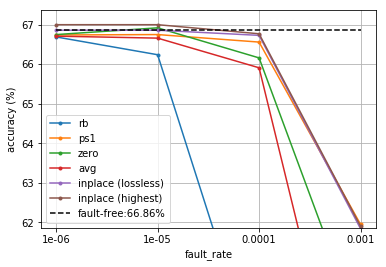

In [7]:
# x: fault_rate, y:accuracy; 
for data_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, data_type)
    assert round(prec1, 2) == fault_free_accuracy, 'checkpoint acc:%.2f, recorded acc:%.2f' %(prec1, fault_free_accuracy)
    xticks = ([], [])
    for fault_type in fault_types:

        res = data[data_type][fault_type]
        if 'inplace' in fault_type:
            # the key is a tuple (fault_rate, target_accuracy)
            # option 1: use only the target accuracy the same as the fault-free accuracy 
            # TODO: the fault-free accuracy may not inside the key 
            keys = sorted(res.keys(), key=lambda x: (x[0], x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            
            fault_rates = [x[0] for x in selected_keys]
            x = np.log10(fault_rates)
            accuracies = [np.median(res[n_bits], axis=0)[-1] for n_bits in selected_keys]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1]+' (lossless)', marker='.')
            
            # option 2: use the highest target accuracy
            keys = sorted(res.keys(), key=lambda x: (x[0], -x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            
            fault_rates = [x[0] for x in selected_keys]
            x = np.log10(fault_rates)
            accuracies = [np.median(res[n_bits], axis=0)[-1] for n_bits in selected_keys]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1] + ' (highest)', marker='.')
        else:

            fault_rates = sorted(res.keys())
            print('fault_rates', fault_rates)
            x = np.log10(fault_rates)
            accuracies = [np.median(res[n_bits], axis=0)[-1] for n_bits in fault_rates]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1], marker='.')
            
        if len(x) > len(xticks[0]):
            xticks = (x, [s for s in map(str, fault_rates)])
    plt.ylim(fault_free_accuracy-5, fault_free_accuracy+0.5)
    plt.grid()
    plt.ylabel('accuracy (%)')
    plt.xlabel('fault_rate')
#     plt.title('%s' %(fault_type))
    plt.xticks(xticks[0], xticks[1])
    plt.plot(xticks[0], [fault_free_accuracy]*len(xticks[0]), color='k', linestyle='--', 
             label='fault-free:%.2f%%' %(fault_free_accuracy))
    plt.legend()    
    plt.show()


fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb , accuracies 0.17, 0.62, 8.66, 64.98
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_ps1 , accuracies 0.12, 0.11, 0.30, 4.91
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_parity_zero , accuracies 0.11, -0.06, 0.70, 7.62
fault_rates [1e-06, 1e-05, 0.0001, 0.001]
faults_network_rb_parity_avg , accuracies 0.15, 0.20, 0.95, 11.45
selected_keys [(1e-06, 0.0), (1e-05, 0.0), (0.0001, 0.0), (0.001, 0.0)]
faults_network_rb_inplace , accuracies 0.00, 0.00, 0.13, 5.02
selected_keys [(1e-06, 67.0), (1e-05, 67.0), (0.0001, 67.0), (0.001, 67.0)]
faults_network_rb_inplace , accuracies -0.14, -0.14, 0.09, 4.96


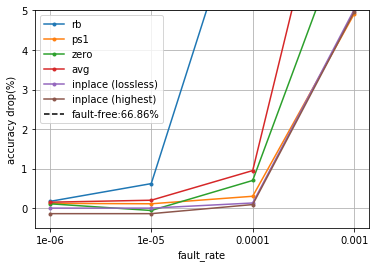

In [8]:
# x: fault_rate, y:accuracy; 
for data_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, data_type)
    xticks = ([], [])
    for fault_type in fault_types:

        res = data[data_type][fault_type]
        if 'inplace' in fault_type:
            # the key is a tuple (fault_rate, target_accuracy)
            # option 1: use only the target accuracy the same as the fault-free accuracy 
            keys = sorted(res.keys(), key=lambda x: (x[0], x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            
            fault_rates = [x[0] for x in selected_keys]
            x = np.log10(fault_rates)
            accuracies = [fault_free_accuracy - np.median(res[n_bits], axis=0)[-1] for n_bits in selected_keys]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1]+' (lossless)', marker='.')
            
            # option 2: use the highest target accuracy
            keys = sorted(res.keys(), key=lambda x: (x[0], -x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            
            fault_rates = [x[0] for x in selected_keys]
            x = np.log10(fault_rates)
            accuracies = [fault_free_accuracy - np.median(res[n_bits], axis=0)[-1] for n_bits in selected_keys]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1] + ' (highest)', marker='.')
        else:

            fault_rates = sorted(res.keys())
            print('fault_rates', fault_rates)
            x = np.log10(fault_rates)
            accuracies = [fault_free_accuracy - np.median(res[n_bits], axis=0)[-1] for n_bits in fault_rates]
            print(fault_type, ', accuracies', ', '.join(['%.2f' %(a) for a in accuracies]))
            plt.plot(x, accuracies, label=fault_type.split('_')[-1], marker='.')
            
        if len(x) > len(xticks[0]):
            xticks = (x, [s for s in map(str, fault_rates)])
    plt.ylim(-0.5, 5)
    plt.grid()
    plt.ylabel('accuracy drop(%)')
    plt.xlabel('fault_rate')
#     plt.title('%s' %(fault_type))
    plt.xticks(xticks[0], xticks[1])
    plt.plot(xticks[0], [fault_free_accuracy]*len(xticks[0]), color='k', linestyle='--', 
             label='fault-free:%.2f%%' %(fault_free_accuracy))
    plt.legend()    
    plt.show()


fault_type fault_rate      0      1      2      3      4
        rb      1e-06  66.90  66.60  66.64  66.70  66.90  66.56  67.20  66.48  66.90  66.68 
        rb      1e-05  66.48  65.74  60.88  66.12  66.36  66.38  65.76  66.58  65.90  67.20 
        rb     0.0001  57.82  59.12  51.66  59.96  48.20  58.50  58.64  57.90  59.64  56.46 
        rb      0.001   2.00   3.08   1.90   1.78   1.54   0.16   1.52   1.86   6.68   2.58 
       ps1      1e-06  66.74  66.72  66.92  66.54  66.46  66.78  66.80  66.74  66.92  66.74 
       ps1      1e-05  66.56  66.86  66.64  66.70  66.94  66.60  66.80  66.68  66.90  66.84 
       ps1     0.0001  66.10  66.54  66.30  66.46  66.68  67.00  66.34  66.58  66.70  66.82 
       ps1      0.001  63.46  61.28  64.00  60.68  64.26  60.38  56.42  62.70  62.62  60.06 
      zero      1e-06  66.82  67.04  66.92  66.68  66.68  66.36  66.66  66.86  66.94  66.60 
      zero      1e-05  66.92  66.92  65.14  66.88  67.02  67.40  66.62  67.08  66.54  67.16 
      zero   

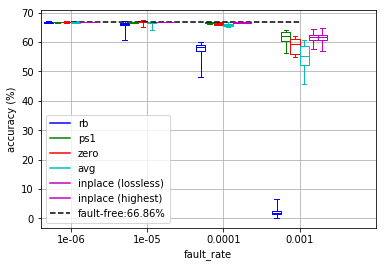

In [16]:
# x: fault_rate, y:accuracy; lengends: param_id 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
def print_accuracy(fault_type, fault_rates, accuracies):
    for a, b in zip(fault_rates, accuracies):
        b = ['%.2f' %(v) for v in b]
        bstr_format = '%6s '*len(b)
        print_format = '%10s %10s '+bstr_format
        print( print_format %(fault_type, a, *b))
        
for model_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
#     colors = ['k', 'r', 'b', 'g', 'y'] 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    n_space = len(fault_types)
    offset = -0.3*n_space
    print('%10s %10s %6s %6s %6s %6s %6s' 
          %('fault_type', 'fault_rate', '0', '1', '2', '3', '4'))
    
    
    for i, fault_type in enumerate(fault_types):
        res = data[data_type][fault_type]
        if 'inplace' in fault_type:
            # option 1: use only the target accuracy the same as the fault-free accuracy 
            keys = sorted(res.keys(), key=lambda x: (x[0], x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            fault_rates = [x[0] for x in selected_keys]
            accuracies = [res[fr][:, 2] for fr in selected_keys]
            print_accuracy('(lossless)', fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, 'm') 
            
            
            # option 2: use the highest target accuracy
            keys = sorted(res.keys(), key=lambda x: (x[0], -x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            fault_rates = [x[0] for x in selected_keys]
            accuracies = [res[fr][:, 2] for fr in selected_keys]
            print_accuracy('(highest)', fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[i]) 
            
        else:
            fault_rates = sorted(res.keys())
            accuracies = [res[fr][:, 2] for fr in fault_rates]
            print_accuracy(fault_type.split('_')[-1], fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                              positions=np.array(range(len(accuracies)))*n_space+offset, 
                              sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[i]) 


    # draw temporary red and blue lines and use them to create a legend
    for i, fault_type in enumerate(fault_types):
        if 'inplace' in fault_type:
            plt.plot([], c='m', label=fault_type.split('_')[-1]+' (lossless)')
            plt.plot([], c='m', label=fault_type.split('_')[-1]+' (highest)')
        else:
            plt.plot([], c=colors[i], label=fault_type.split('_')[-1])
            
            

    x = range(0, len(fault_rates) * n_space, n_space)
    plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates])

    plt.xlim(-2, len(fault_rates)*n_space)
    plt.ylim(fault_free_accuracy-10,fault_free_accuracy+0.5)
    plt.grid()
    plt.ylabel('accuracy (%)')
    plt.xlabel('fault_rate')
    plt.plot(x, [fault_free_accuracy]*len(x), color='k', linestyle='--',
             label='fault-free:%.2f%%' %(fault_free_accuracy))   
    plt.legend()
    plt.show()


fault_type fault_rate      0      1      2      3      4
        rb      1e-06  -0.04   0.26   0.22   0.16  -0.04   0.30  -0.34   0.38  -0.04   0.18 
        rb      1e-05   0.38   1.12   5.98   0.74   0.50   0.48   1.10   0.28   0.96  -0.34 
        rb     0.0001   9.04   7.74  15.20   6.90  18.66   8.36   8.22   8.96   7.22  10.40 
        rb      0.001  64.86  63.78  64.96  65.08  65.32  66.70  65.34  65.00  60.18  64.28 
       ps1      1e-06   0.12   0.14  -0.06   0.32   0.40   0.08   0.06   0.12  -0.06   0.12 
       ps1      1e-05   0.30   0.00   0.22   0.16  -0.08   0.26   0.06   0.18  -0.04   0.02 
       ps1     0.0001   0.76   0.32   0.56   0.40   0.18  -0.14   0.52   0.28   0.16   0.04 
       ps1      0.001   3.40   5.58   2.86   6.18   2.60   6.48  10.44   4.16   4.24   6.80 
      zero      1e-06   0.04  -0.18  -0.06   0.18   0.18   0.50   0.20   0.00  -0.08   0.26 
      zero      1e-05  -0.06  -0.06   1.72  -0.02  -0.16  -0.54   0.24  -0.22   0.32  -0.30 
      zero   

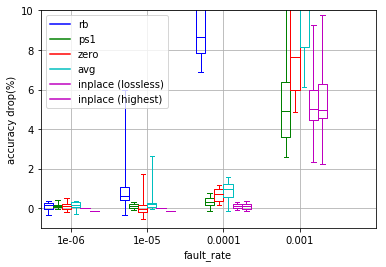

In [10]:
# x: fault_rate, y:accuracy; lengends: param_id 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
def print_accuracy(fault_type, fault_rates, accuracies):
    for a, b in zip(fault_rates, accuracies):
        b = ['%.2f' %(v) for v in b]
        bstr_format = '%6s '*len(b)
        print_format = '%10s %10s '+bstr_format
        print( print_format %(fault_type, a, *b))
        
for model_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
#     colors = ['k', 'r', 'b', 'g', 'y'] 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 
    n_space = len(fault_types)
    offset = -0.3*n_space
    print('%10s %10s %6s %6s %6s %6s %6s' 
          %('fault_type', 'fault_rate', '0', '1', '2', '3', '4'))
    
    
    for i, fault_type in enumerate(fault_types):
        res = data[data_type][fault_type]
        if 'inplace' in fault_type:
            # option 1: use only the target accuracy the same as the fault-free accuracy 
            keys = sorted(res.keys(), key=lambda x: (x[0], x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            fault_rates = [x[0] for x in selected_keys]
            accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in selected_keys]
            print_accuracy('(lossless)', fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, 'm') 
            
            
            # option 2: use the highest target accuracy
            keys = sorted(res.keys(), key=lambda x: (x[0], -x[1]))
            selected_keys = [] 
            for key in keys:
                if not selected_keys:
                    selected_keys.append(key)
                elif key[0] != selected_keys[-1][0]:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            fault_rates = [x[0] for x in selected_keys]
            accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in selected_keys]
            print_accuracy('(highest)', fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[i]) 
            
        else:
            fault_rates = sorted(res.keys())
            accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in fault_rates]
            print_accuracy(fault_type.split('_')[-1], fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                              positions=np.array(range(len(accuracies)))*n_space+offset, 
                              sym='', widths=0.6, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[i]) 


    # draw temporary red and blue lines and use them to create a legend
    for i, fault_type in enumerate(fault_types):
        if 'inplace' in fault_type:
            plt.plot([], c='m', label=fault_type.split('_')[-1]+' (lossless)')
            plt.plot([], c='m', label=fault_type.split('_')[-1]+' (highest)')
        else:
            plt.plot([], c=colors[i], label=fault_type.split('_')[-1])
            
            

    x = range(0, len(fault_rates) * n_space, n_space)
    plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates])

    plt.xlim(-2, len(fault_rates)*n_space)
    plt.ylim(-1, 10)
    plt.grid()
    plt.ylabel('accuracy drop(%)')
    plt.xlabel('fault_rate')
#     plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', 
#              label='fault-free:%.2f%%' %(fault_free_accuracy))   
    plt.legend()
    plt.show()

In [11]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

# def parse_stats_dict(stats):
#     # input format:
#     # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
#     # output format: 
#     # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
#     param_stats = {'changed_params':0, 
#                    'flip_to_one': np.zeros(8, dtype='int'), 
#                    'flip_to_zero': np.zeros(8, dtype='int'),
#                   'value_before_flip': [],
#                   'value_after_flip':[], 
#                   'flipped_positions': []}
#     for weight_id, value_dict in stats.items():       
#         for value_id, flip_list in value_dict.items():
#             param_stats['changed_params'] += 1
#             param_stats['value_before_flip'].append(flip_list[0][0])
#             param_stats['value_after_flip'].append(flip_list[-1][-1])
#             param_stats['flipped_positions'].append([x[1] for x in flip_list])

#             for _, flip_pos, flip_bit, flip_value in flip_list:
#                 if flip_bit:
#                     param_stats['flip_to_one'][flip_pos] += 1
#                 else:
#                     param_stats['flip_to_zero'][flip_pos] += 1
#     return param_stats 

def parse_stats(stats):
    param_stats = {'changed_params':0, 
                   'flip_to_one': np.zeros(8, dtype='int'), 
                   'flip_to_zero': np.zeros(8, dtype='int'),
                  'value_before_flip': [],
                  'value_after_flip':[], 
                   'value_after_correction':[],
                  'flipped_positions': []}
    for weight_id, value_tuple in stats.items(): 
        if isinstance(value_tuple, tuple):
            value_dict, corr_dict = value_tuple 
        else:
            value_dict, corr_dict = value_tuple, None 
        
        for value_id, flip_list in value_dict.items():
            param_stats['changed_params'] += 1
            param_stats['value_before_flip'].append(flip_list[0][0])
            param_stats['value_after_flip'].append(flip_list[-1][-1])
            param_stats['flipped_positions'].append([x[1] for x in flip_list])
            
            if corr_dict:
                if value_id in corr_dict:
                    assert corr_dict[value_id][0] == flip_list[-1][-1]
                    param_stats['value_after_correction'].append(corr_dict[value_id][-1])
                else:
                    param_stats['value_after_correction'].append(flip_list[-1][-1])

            for _, flip_pos, flip_bit, flip_value in flip_list:
                if flip_bit:
                    param_stats['flip_to_one'][flip_pos] += 1
                else:
                    param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f, verbose=False)
        for item in stats:
            print(item, stats[item])
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    


fault_type: faults_network_rb
accuracies: [66.9  66.6  66.64 66.7  66.9  66.56 67.2  66.48 66.9  66.68]
24 defaultdict(<class 'list'>, {132284: [(25, 7, False, 24)], 17495: [(-1, 4, False, -9)]})
25 defaultdict(<class 'list'>, {112673: [(-1, 3, False, -17)], 44170: [(20, 2, True, 52)], 60500: [(10, 5, True, 14)], 511204: [(31, 6, False, 29)], 31254: [(29, 4, False, 21)]})
21 defaultdict(<class 'list'>, {804: [(0, 7, True, 1)]})
22 defaultdict(<class 'list'>, {11694: [(-25, 7, False, -26)]})
flip_to_one: [0 0 1 0 0 1 0 1], flip_to_zero: [0 0 0 1 2 0 1 2]
#changed_values: 9 , #flipped_bits: 9 , #changed_values: 9 , #flipped_bits: 9

fault_type: faults_network_rb_ps1
accuracies: [66.74 66.72 66.92 66.54 66.46 66.78 66.8  66.74 66.92 66.74]
24 (defaultdict(<class 'list'>, {73202: [(-15, 1, False, -79)], 32414: [(-4, 3, False, -20)]}), {73202: (-79, -15, True)})
25 (defaultdict(<class 'list'>, {153577: [(-11, 4, True, -3)], 124828: [(1, 0, True, -127)], 259974: [(-3, 1, False, -67)], 10971

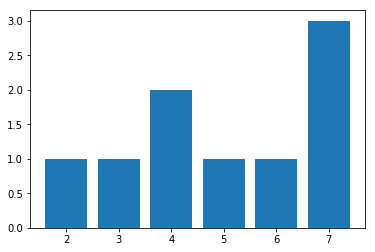

In [12]:

model_type = 'int8'
fault_rate = 1e-6
target_accuracy = 0
markers = ['o', '+']
for fi, fault_type in enumerate(fault_types):
    print('\nfault_type:', fault_type)
    
    if 'inplace' in fault_type:
        folder = 'r%s/%.2f' %( fault_rate, target_accuracy)
        print('accuracies:', data[model_type][fault_type][(fault_rate, target_accuracy)][:, 2])
    else:
        folder = 'r%s' %(fault_rate)
        print('accuracies:', data[model_type][fault_type][fault_rate][:, 2])
    results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

    avg_params_stats = load_and_average_stats(results_dir, [0])
    # print(avg_params_stats)
    print('flip_to_one: %s, flip_to_zero: %s' 
          %(avg_params_stats['flip_to_one'], avg_params_stats['flip_to_zero']))
    
    print('#changed_values:', len(avg_params_stats['value_before_flip']), 
          ', #flipped_bits:', sum(avg_params_stats['flip_to_one'])+sum(avg_params_stats['flip_to_zero']),
         ', #changed_values:', len(avg_params_stats['flipped_positions']),
         ', #flipped_bits:',sum([len(x) for x in avg_params_stats['flipped_positions']]))
    
#     num_values_show = 100 
#     print(list(zip(avg_params_stats['value_before_flip'][:num_values_show], 
#                    avg_params_stats['flipped_positions'][:num_values_show],
#                    avg_params_stats['value_after_flip'][:num_values_show])))

#     check = [(avg_params_stats['value_before_flip'][i], 
#                   avg_params_stats['flipped_positions'][i], 
#                  avg_params_stats['value_after_flip'][i]) 
#              for i, item in enumerate(avg_params_stats['flipped_positions'])
#                                      if (0 in item or 1 in item or 2 in item) and 
#             avg_params_stats['value_before_flip'][i]!=avg_params_stats['value_after_flip'][i]]
#     print(len(check), check)
    
#     plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 
#              marker=markers[fi%2], label=fault_type, linestyle='')
#     plt.xlabel('value_before_flip')
#     plt.ylabel('value_after_flip')
    
    
# plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
# plt.legend()
# plt.title('fault_rate: %s' %(fault_rate))
# plt.show()

import collections 
counter = collections.Counter([x for y in avg_params_stats['flipped_positions'] for x in y ])
counts = sorted(counter.items(), key=lambda x: x[0])
counts = list(zip(*counts))
plt.bar(counts[0], counts[1])
plt.show()
             
                               

In [13]:
# import torch 

# model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = checkpoint['prec1']
# print('prec1:', prec1)
# state_dict = checkpoint['state_dict']
# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     plt.hist(tensor.cpu().numpy().ravel(), bins=100)
#     plt.title(key+' [%d, %d]' %(minv, maxv))
#     plt.show()